<a href="https://colab.research.google.com/github/Stroded4ever/MQP/blob/main/VIXSCRIPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Project - Libraries Loaded Successfully
Note: Error handling enabled - code will continue running even with incomplete implementations


[*********************100%***********************]  1 of 1 completed


Ticker,^GSPC
Date,
2014-07-18,1978.219971
2014-07-21,1973.630005
2014-07-22,1983.530029
2014-07-23,1987.010010
2014-07-24,1987.979980


Ticker,^GSPC
Date,
2025-08-07,6340.000000
2025-08-08,6389.450195
2025-08-11,6373.450195
2025-08-12,6445.759766
2025-08-13,6466.580078


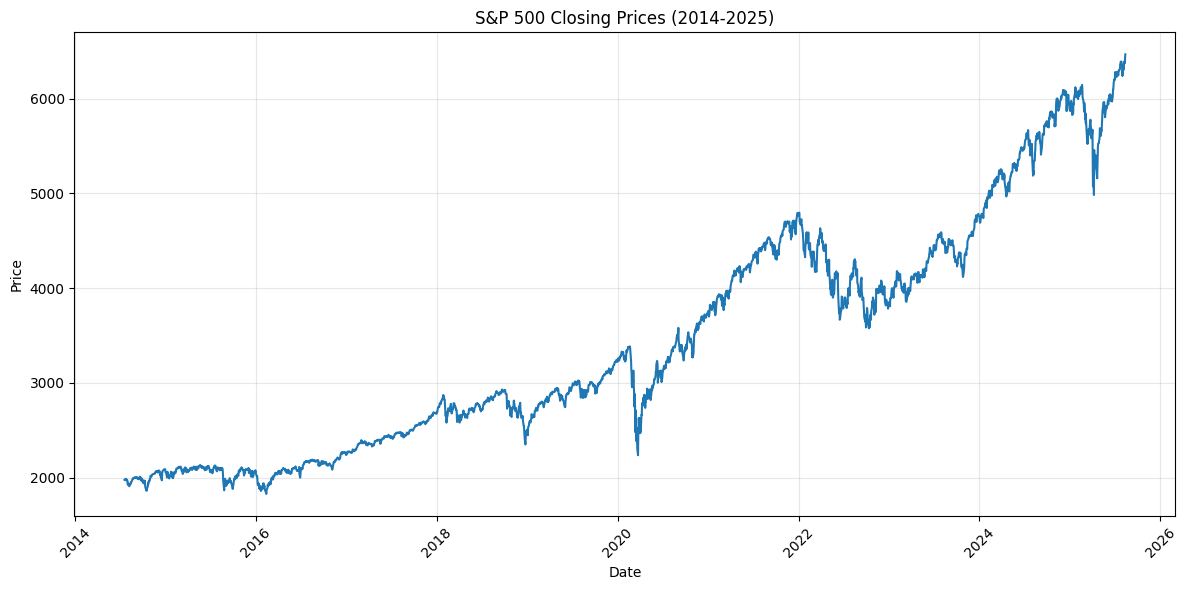

Estimated Parameters:
  ω (omega): 3.191810e-06
  α (alpha): 0.0500
  β (beta):  0.9000
Max Log-Likelihood: 9138.28
Unconditional Volatility (long-term σ): 0.0080


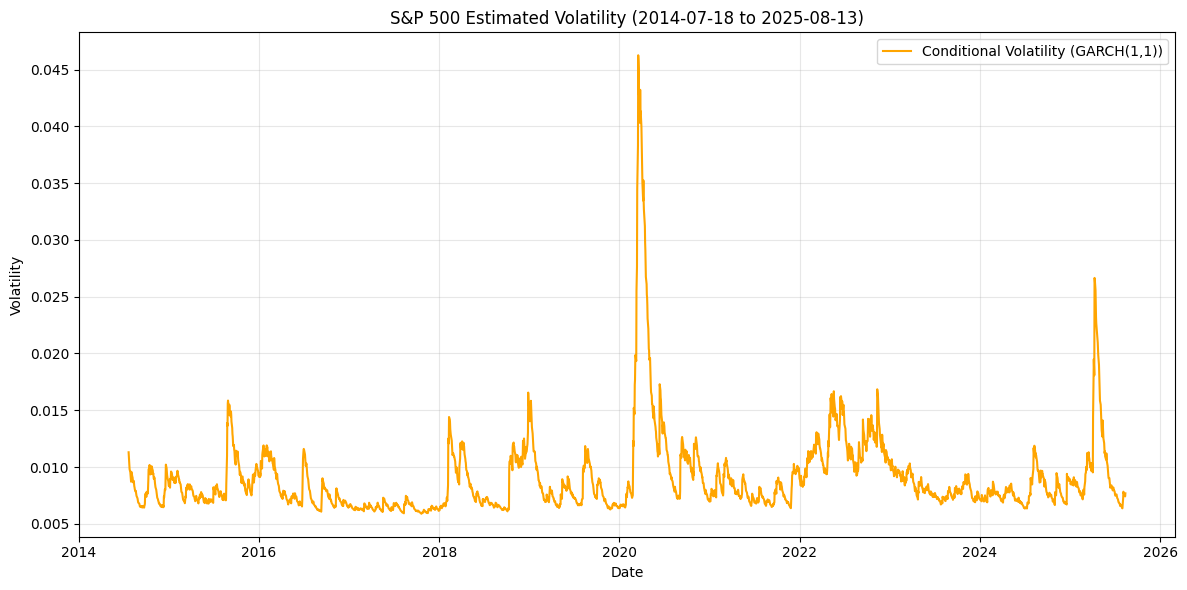

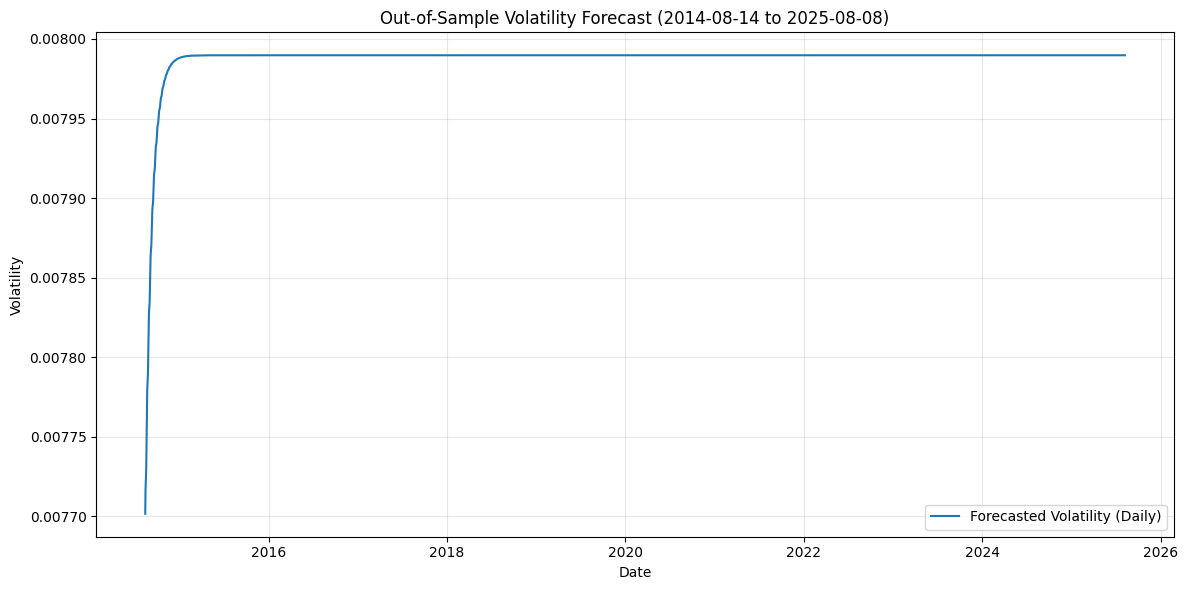

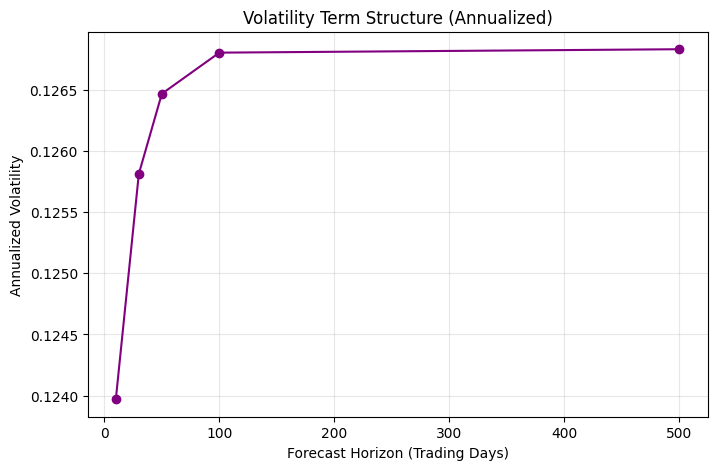

,Horizon (days),Annualized Volatility
0,10,0.123970
1,30,0.125815
2,50,0.126469
3,100,0.126805
4,500,0.126833


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
from scipy.optimize import minimize
import warnings
from IPython.display import display

# Suppress all warnings including type errors
warnings.filterwarnings('ignore')

# Configure numpy to handle errors gracefully
np.seterr(all='ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Project - Libraries Loaded Successfully")
print("=" * 60)
print("Note: Error handling enabled - code will continue running even with incomplete implementations")
import yfinance as yf

# Download SP500 daily close prices from 2005-07-18 to 2010-08-13
sp500 = yf.download('^GSPC', start='2014-07-18', end='2025-08-14')
sp500_close = sp500['Close']
sp500_close = sp500_close.dropna()  # Remove any NaN values
display(sp500_close.head())
display(sp500_close.tail())
S = sp500_close.to_numpy()
S = S.flatten()  # Ensure S is 1D

# Plot the closing prices
# Create date labels for x-axis
dates = sp500_close.index
plt.figure(figsize=(12, 6))
plt.plot(dates, S)
plt.title('S&P 500 Closing Prices (2014-2025)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Compute log returns
returns = np.diff(np.log(S))  # log returns
n = len(returns)
def garch_loglik(params, data):
    omega, alpha, beta = params

    # enforce positivity and stationarity
    if omega <= 0 or alpha < 0 or beta < 0 or alpha + beta >= 1:
        return 1e10  # penalize invalid values

    n = len(data)
    sigma2 = np.zeros(n)
    # initialize with variance of data
    sigma2[0] = np.var(data)

    # recursion
    for t in range(1, n):
        sigma2[t] = omega + alpha * data[t-1]**2 + beta * sigma2[t-1]

    # log-likelihood
    ll = -0.5 * np.sum(np.log(2*np.pi) + np.log(sigma2) + data**2 / sigma2)
    return -ll  # minimize negative log-likelihood
# Initial guesses
init_params = [0.000001, 0.05, 0.9]  # omega, alpha, beta
bounds = [(1e-12, None), (0.0, 1.0), (0.0, 1.0)]

res = minimize(garch_loglik, init_params, args=(returns,), bounds=bounds)

omega, alpha, beta = res.x
max_loglik = -res.fun

print("Estimated Parameters:")
print(f"  ω (omega): {omega:.6e}")
print(f"  α (alpha): {alpha:.4f}")
print(f"  β (beta):  {beta:.4f}")
print(f"Max Log-Likelihood: {max_loglik:.2f}")
uncond_var = omega / (1 - alpha - beta)
uncond_vol = math.sqrt(uncond_var)
print(f"Unconditional Volatility (long-term σ): {uncond_vol:.4f}")
# Recompute conditional variance with estimated params
sigma2 = np.zeros_like(returns)
sigma2[0] = np.var(returns)

for t in range(1, len(returns)):
    sigma2[t] = omega + alpha * returns[t-1]**2 + beta * sigma2[t-1]

cond_vol = np.sqrt(sigma2)
plt.figure(figsize=(12,6))
plt.plot(dates[1:], cond_vol, color="orange", label="Conditional Volatility (GARCH(1,1))")
plt.title("S&P 500 Estimated Volatility (2014-07-18 to 2025-08-13)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
# ================================
# Task 2: Volatility Forecasting and Term Structure
# ================================

# Part A: Out-of-Sample Forecasting
# Forecast horizon (daily) from 2010-08-14 to 2015-08-08
forecast_start = pd.to_datetime("2014-08-14")
forecast_end   = pd.to_datetime("2025-08-08")
forecast_dates = pd.date_range(start=forecast_start, end=forecast_end, freq="B")
horizon = len(forecast_dates)

# Last in-sample variance
sigma2_last = sigma2[-1]
Vl = omega / (1 - alpha - beta)  # long-term variance

# Forecast variance for each horizon using GARCH(1,1) formula
sigma2_forecast = np.zeros(horizon)
for h in range(1, horizon+1):
    sigma2_forecast[h-1] = Vl + (alpha + beta)**h * (sigma2_last - Vl)

forecast_vol = np.sqrt(sigma2_forecast)

# Plot forecasted volatility time series
plt.figure(figsize=(12,6))
plt.plot(forecast_dates, forecast_vol, label="Forecasted Volatility (Daily)")
plt.title("Out-of-Sample Volatility Forecast (2014-08-14 to 2025-08-08)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Part B: Volatility Term Structure
# Horizons in trading days
horizons = np.array([10, 30, 50, 100, 500])
term_vol = []

for h in horizons:
    sigma2_h = Vl + (alpha + beta)**h * (sigma2_last - Vl)
    sigma_h = math.sqrt(sigma2_h)
    sigma_annual = sigma_h * math.sqrt(252)  # annualize
    term_vol.append(sigma_annual)

# Plot volatility term structure
plt.figure(figsize=(8,5))
plt.plot(horizons, term_vol, marker="o", linestyle="-", color="purple")
plt.title("Volatility Term Structure (Annualized)")
plt.xlabel("Forecast Horizon (Trading Days)")
plt.ylabel("Annualized Volatility")
plt.grid(True, alpha=0.3)
plt.show()

# Display term structure values
term_structure_df = pd.DataFrame({
    "Horizon (days)": horizons,
    "Annualized Volatility": term_vol
})
display(term_structure_df)